# Use Case I Risk modeling of claim frequency for a motor vehicle third-party insurance
## 1 Initial situation and libraries
This notebook is a companion document to the xxx results report to make the techniques discussed therein more accessible.

In this use case, we discuss aspects of fairness in sections of the risk modeling of claim frequencies commonly used by composite insurers. The focus here is on the assessment of "fairness" and on how bias and discrimination can be identified. Our aim is not to achieve the best possible replication of risk modeling carried out by composite insurers. Instead, a simple approach is chosen here, both in terms of exploratory data analysis (EDA) and pre-processing as well as the actual core risk modeling. The results are generated on the basis of various models in order to illustrate that the methods used can be applied to a wide range of models and are rather model-independent.

Bias, i.e. distortions in the data or models, can lead to unfair and discriminatory results that disadvantage certain groups of insured persons. In this context, methods and techniques are investigated to identify and minimize such biases. This is of particular importance as risk models in the insurance industry have a direct impact on premiums.

Further details on pre-processing can be found in Use Case II.

### 1.0 Definitions
Let X and D be the explanatory features for the target variable Y. Further, let D denote a protected feature, e.g. gender. It denotes (cf. Lindholm et al. (2023)):
  - Best-Estimate Model: $\mu(X,D) = E(Y|X,D)$
  - Unawareness Model: $\mu(X) = E(Y|X)$
  - Discrimination-Free Model: $\mu(X) = \sum_{d\in D} \mu(X,d) P(D = d)$
    
The claim frequencies are calibrated for three models (logistic regression, random forest and gradient boosting) and then analysed using fairness metrics. In addition, commonly used quality measures of the forecast, e.g. the AUC or the residual deviance, are calculated, which can be taken into account in the selection of the model.  This should demonstrate that the models are suitable for a meaningful discussion in terms of fairness.

### 1.1 Data set
In this study, the FreMTPL2 dataset, which is available on the Kaggle data platform (source: https://www.kaggle.com/datasets/karansarpal/fremtpl2-french-motor-tpl-insurance-claims), was used as a starting point. This dataset was enriched with synthetic data.We added a gender feature to the data setthat represents the protected feature in the further course. Furthermore, an indirect bias was introduced with regard to gender, which is induced by the variable "VehPower" for the engine power of the vehicle, which already exists in freMTPL2. Here,  the proportion of men in the data set increases with increasing engine power.

The second modification to the data set concerns the target variable. The binary column "ClaimsVP", which is related to the engine power "VehPower" and indicates whether there is a claim (1) or not (0), was also synthetically enriched. This adjustment to the information on claim frequency already available in the data set was necessary to ensure that there was a direct relationship between the target variable (claim yes/no), the sensitive feature (gender) and its proxy feature (engine power) that could be modified by the authors.

The data enrichment process, including the methodology for generating the synthetic data and the introduction of the bias, is documented in detail in a separate Jupyter Notebook. This notebook can be made available upon request.
This modified version of the data set forms the basis for further investigations into fairness in insurance models and for the development of methods for detecting and mitigating bias in machine learning algorithms  in the context of the frequent task of actuaries in the insurance industry.

#### 1.1.1 Column description
- **Exposure:** The exposure period of a policy in years.
- **VehPower:** The power of the car (ordered values).
- **VehAge:** The age of the vehicle in years.
- **DrivAge:** The age of the driver in years (in France, people aged 18 and over are allowed to drive).
- **BonusMalus:** Bonus/malus, between 50 and 350: <100 means bonus, >100 means malus in France.
- **VehBrand:** The car brand (unknown categories).
- **VehGas:** The fuel of the car, diesel or normal.
- **Area:** The density value of the urban community in which the driver lives: from "A" for rural areas to "F" for city centers.
- **Density:** The population density (number of inhabitants per square kilometer) of the city in which the driver lives.
- **Region:** The policy region in France (based on the 1970-2015 classification)
- **ClaimsVP:** Synthetically created column, correlates with VehPower, where 1 = damage and 0 = no damage
- **SexVP:** Synthetically created column, correlates with VehPower, where 0 = man and 1 = woman

### 1.2. Importing libraries
In the following, we use various metrics to determine fairness from the Fairlearn package, among others. https://fairlearn.org/. However, we also improved the functionalities from the package to better fit our needs.


In [11]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
import fairlearn as fl

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost import plot_importance

from fairlearn.metrics import (
    demographic_parity_difference,
    demographic_parity_ratio,
    equalized_odds_difference,
    equalized_odds_ratio
)

### 1.3 Data import and pre-processing
One-hot encoding is a technique for converting categorical variables into a form that can be better processed by machine learning algorithms. A new column is created for each unique category of a variable. If a data set belongs to this category, it receives a 1 in the corresponding column, otherwise a 0. This makes it possible to convert categorical data into a numerical format without implying an ordinal relationship between the categories.

In a next step of Eda, a correlation matrix is considered. Due to the obsvious high correlation between Density and Area, Density is eliminated for further modeling. No further data pre-processing steps are carried out.

In [12]:
#Import
df = pd.read_csv("C:/Users/Max.Bagus/OneDrive - viadico GmbH/Dokumente/Dokumente/DAV/AG Bias und Diskriminierung/Analyse freMTPL/freMTPL2freq_VP.csv", sep=",", decimal='.')

In [13]:
df_model = df.copy()
print(df_model.head(5))

#One-Hot-Encoding
categorical_columns = df_model.select_dtypes(include=['object']).columns.tolist()
encoder = sk.preprocessing.OneHotEncoder(sparse_output=False)
one_hot_encoded = encoder.fit_transform(df_model[categorical_columns])
one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(categorical_columns))

df_model_encoded = pd.concat([df_model, one_hot_df], axis=1)
df_model_encoded = df_model_encoded.drop(categorical_columns, axis=1)

   Exposure Area  VehPower  VehAge  DrivAge  BonusMalus VehBrand   VehGas  \
0      0.10    D         5       0       55          50      B12  Regular   
1      0.77    D         5       0       55          50      B12  Regular   
2      0.75    B         6       2       52          50      B12   Diesel   
3      0.09    B         7       0       46          50      B12   Diesel   
4      0.84    B         7       0       46          50      B12   Diesel   

   Density Region  SexVP  ClaimsVP  
0     1217    R82    1.0         0  
1     1217    R82    1.0         0  
2       54    R22    1.0         1  
3       76    R72    1.0         1  
4       76    R72    0.0         0  


In [14]:
#Korrelationsmatrix
corr = df_model_encoded.corr()
corr.style.background_gradient(cmap='coolwarm')

,Exposure,VehPower,VehAge,DrivAge,BonusMalus,Density,SexVP,ClaimsVP,Area_A,Area_B,Area_C,Area_D,Area_E,Area_F,VehBrand_B1,VehBrand_B10,VehBrand_B11,VehBrand_B12,VehBrand_B13,VehBrand_B14,VehBrand_B2,VehBrand_B3,VehBrand_B4,VehBrand_B5,VehBrand_B6,VehGas_Diesel,VehGas_Regular,Region_R11,Region_R21,Region_R22,Region_R23,Region_R24,Region_R25,Region_R26,Region_R31,Region_R41,Region_R42,Region_R43,Region_R52,Region_R53,Region_R54,Region_R72,Region_R73,Region_R74,Region_R82,Region_R83,Region_R91,Region_R93,Region_R94
Exposure,1.000000,-0.045259,0.151554,0.171873,-0.183018,-0.071085,0.013342,-0.009975,0.078650,0.040064,0.026885,-0.029491,-0.087724,-0.034379,0.088165,0.003386,-0.008527,-0.216243,0.010145,0.007073,0.098557,0.005413,0.009890,0.029664,0.011893,-0.040123,0.040123,-0.089143,-0.023931,-0.024461,-0.052496,0.169387,0.028912,-0.017125,-0.060315,0.036764,0.003264,-0.012560,0.025182,0.091901,0.026767,-0.043241,-0.052675,-0.000931,0.006544,-0.021745,-0.075924,-0.077409,-0.030942
VehPower,-0.045259,1.000000,-0.006001,0.030108,-0.075895,0.042901,-0.245880,0.199974,0.008624,-0.000462,-0.004465,-0.012140,-0.007962,0.045500,-0.078243,0.202855,0.171280,0.111496,0.081079,0.016937,-0.112497,-0.024299,-0.049075,-0.042854,-0.049412,0.059163,-0.059163,0.044286,0.000899,0.009778,-0.002331,-0.033091,0.000141,-0.000827,-0.028197,-0.016130,0.001338,0.001679,-0.008905,-0.018427,0.000588,-0.002539,0.001448,-0.000961,0.025803,0.005146,-0.001232,0.014620,0.010317
VehAge,0.151554,-0.006001,1.000000,-0.059213,0.079923,-0.090428,0.004582,-0.002926,0.076926,0.024687,0.003636,-0.010328,-0.053306,-0.071009,0.192261,0.044137,0.024705,-0.447256,0.029839,0.046103,0.155992,0.023985,0.006955,0.061334,0.023295,-0.127169,0.127169,-0.134085,-0.035727,-0.028245,-0.007973,0.187622,0.002200,-0.022102,-0.028255,-0.006923,-0.008401,-0.007993,0.046147,0.031109,0.041237,-0.026133,-0.056379,0.001237,0.009266,-0.033777,-0.038473,-0.066789,-0.045882
DrivAge,0.171873,0.030108,-0.059213,1.000000,-0.479966,-0.004700,-0.004579,0.005379,0.037748,0.007622,0.012515,-0.020213,-0.037814,0.012313,-0.004627,0.021943,-0.020913,0.078852,-0.001302,0.000209,0.021999,-0.089092,-0.042210,-0.020091,-0.026250,-0.071690,0.071690,-0.020961,-0.004799,-0.027775,-0.016886,0.025150,0.002781,-0.003380,-0.066738,0.029675,-0.002434,-0.015903,-0.012803,0.018298,0.002083,0.004647,-0.001671,-0.001692,-0.018961,0.001865,0.007833,0.039394,0.002345
BonusMalus,-0.183018,-0.075895,0.079923,-0.479966,1.000000,0.077717,0.015212,-0.015924,-0.066459,-0.043264,-0.046021,0.040947,0.087408,0.038042,-0.003344,-0.029118,-0.000140,-0.034590,-0.010382,-0.007220,-0.001479,0.044774,0.023008,0.018535,0.015087,-0.031422,0.031422,0.059797,0.000575,0.024383,0.002452,-0.032989,-0.006107,0.006824,0.047696,-0.024124,0.005965,0.010014,-0.009827,-0.035260,0.001537,-0.005406,-0.009039,-0.011304,0.014091,-0.006197,0.003375,-0.016929,0.007045
Density,-0.071085,0.042901,-0.090428,-0.004700,0.077717,1.000000,-0.011972,0.008827,-0.189727,-0.153744,-0.244959,-0.097132,0.329219,0.842500,-0.048669,0.000439,0.003724,0.129599,0.003924,0.006691,-0.066434,-0.005162,-0.009796,-0.018179,-0.005572,-0.099029,0.099029,0.538516,-0.014803,-0.025017,-0.004729,-0.187319,-0.033454,-0.037496,-0.010510,-0.029391,-0.001015,-0.014335,-0.045147,-0.075642,-0.056553,-0.032829,-0.031680,-0.031164,0.039796,-0.022844,-0.068134,-0.016978,-0.026026
SexVP,0.013342,-0.245880,0.004582,-0.004579,0.015212,-0.011972,1.000000,-0.014207,-0.000048,0.001823,0.000222,0.003105,-0.000092,-0.011913,0.023208,-0.052176,-0.045664,-0.034999,-0.017819,-0.005969,0.031332,0.008328,0.010769,0.013456,0.010643,-0.008185,0.008185,-0.011630,-0.001758,-0.003013,-0.001117,0.011464,0.000964,-0.001687,0.006076,0.007577,-0.000984,0.000734,0.002513,0.006941,0.001654,0.000540,-0.001658,0.000461,-0.006157,-0.000184,-0.000855,-0.008271,-0.005095
ClaimsVP,-0.009975,0.199974,-0.002926,0.005379,-0.015924,0.008827,-0.014207,1.000000,-0.000091,0.000207,0.000183,-0.002831,-0.001547,0.010504,-0.018894,0

The adjustments to the data can be found in the correlation matrix:
- VehPower and ClaimsVP: The correlation is 0.19997. This indicates a positive correlation. This means that as vehicle power increases, the number of claims also tends to increase, which is not surprising as this correlation was built in beforehand
- VehPower and SexVP: The correlation is negative at -0.24588. This means that the higher the vehicle power, the more likely it is to contain men (value = 0). This correlation was also built in beforehand.
- SexVP and ClaimsVP have only a weak negative correlation of -0.014. The two effects of data manipulation roughly cancel each other out here. 

Strongest positive correlations:
- Density and Area_F: 0.842500

Strongest negative correlations:
- DrivAge and BonusMalus: -0.479966
- VehBrand_B12 and VehAge: -0.447256

Regional differences: There are some weak to moderate correlations between the different regions and other variables, which could indicate regional differences in terms of vehicle types driving behavior. 

Overall, the matrix shows that most variables are only weakly correlated with each other. The strongest correlations are found between logically related variables (such as diesel vs. regular fuel) or between geographical and demographic factors.


In [15]:
df_model_encoded = df_model_encoded.drop(['Density'],axis=1)

## 2 Checking the requirement for indirect discrimination: estimating the protected characteristic
First, we examine the existence of indirect discrimination. This procedure is transferable to the usual actuarial applications. (https://openaccess.city.ac.uk/id/eprint/30549/1/Fairness_submitted.pdf). The protected feature must fulfill two necessary criteria such that indirect discrimination exists at all (see Remark 2.3 in Lindholm et al. (2023)):
1. The protected feature must be able to be estimated by the other characteristics: (there are possible proxies in the data)  $$P(D=d|X) \neq P(D=d) \text{ for any } d \in D$$
2. The protected feature must be useful for predicting the target variable, i.e. it should apply: $$\mu(X,d) \neq \mu(X) \text{ for any } d \in D$$

We use an XGBoost model to predict the protected feature by all other features. Other machine learning algorithms provide comparable results.

In [16]:
#Daten definieren
X = df_model_encoded.drop(['SexVP','ClaimsVP'],axis=1)
y = df_model_encoded.SexVP

# train and test split
X_train,X_test,y_train,y_test = sk.model_selection.train_test_split(X,y,test_size=0.33,random_state=42,stratify=y)
print("Verteilung SexVP Traingsdatensatz: ")
print(y_train.value_counts(normalize=True))
print("Verteilung SexVP Testdatensatz: ")
print(y_test.value_counts(normalize=True))

Verteilung SexVP Traingsdatensatz: 
1.0    0.504535
0.0    0.495465
Name: SexVP, dtype: float64
Verteilung SexVP Testdatensatz: 
1.0    0.504534
0.0    0.495466
Name: SexVP, dtype: float64


Computed AUC using sklearn.metrics.auc: 0.618


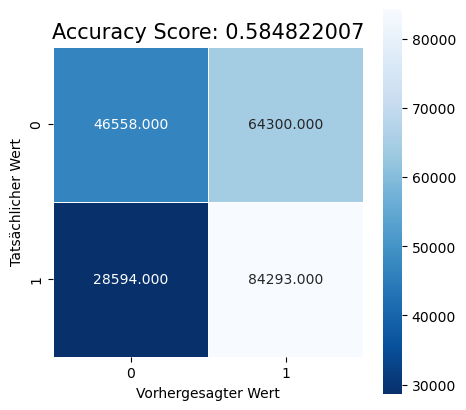

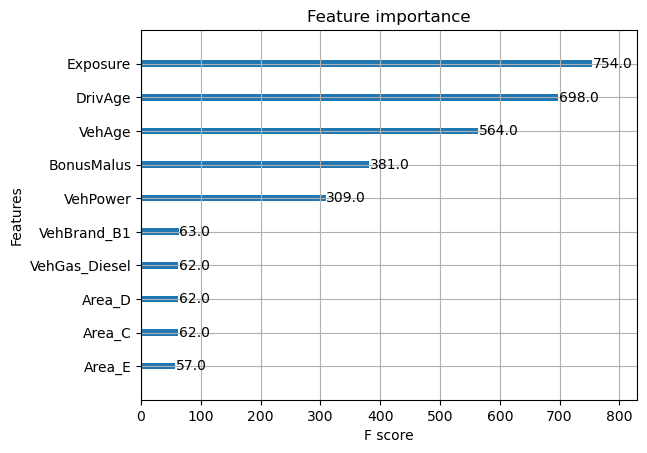

In [17]:
#Modellbildung
xgb_cl_sex = xgb.XGBClassifier(random_state = 42,
                              eval_metric = 'logloss',
                              tree_method = 'hist',
                              enable_categorical = True) 
xgb_cl_sex.fit(X_train, y_train)

#Validierung
xgb_pred_sex = xgb_cl_sex.predict(X_test)
score = sk.metrics.accuracy_score(y_test, xgb_pred_sex)

xgb_pred_sex_prob = xgb_cl_sex.predict_proba(X_test)
print('Computed AUC using sklearn.metrics.auc: {0}'.format(round(sk.metrics.roc_auc_score(y_test,xgb_pred_sex_prob[:,1]),3)))


# Erstellen der Confusion Matrix 
cm = sk.metrics.confusion_matrix(y_test, xgb_pred_sex)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Tatsächlicher Wert');
plt.xlabel('Vorhergesagter Wert');
all_sample_title = 'Accuracy Score: {0}'.format(round(score,9))
plt.title(all_sample_title, size = 15);

plot_importance(xgb_cl_sex,max_num_features = 10)
# show plot
plt.show()

Gender can already be predicted better than random (AUC = 0.5) with the available data and without great effort. It can be assumed that it is possible to find proxy variables for gender, i.e. the first necessary criteria is fulfilled $$P(D=d|X) \neq P(D=d) \text{ for any } d \in D$$

The second necessary criteria can be evaluated by comparing the Unawareness Model and the Best Estimate Model.

## 3 Unawareness model for the modeling of ClaimsVP
The number of claims is highly unbalanced, with approx. 5% claims compared to approx. 95% non-claims. This must be taken into account in the calibration for some models. Therefore, the log-loss is chosen as the optimization measure. This enables a good and at the same time true-to-expectation estimator and thus an objective comparison across different models. Alternatives such as up/downsampling or the use of weights usually lead to estimators that are biased to the minority class. This is important for comparability using fairness metrics (Chapter 5). The exposure was only used as a weighting. No additional standardization of the target variable with the exposure was carried out at this point.

On the one hand, the models are evaluated on the basis of their deviance. This allows an objective comparison to be made at the level of the target function. Other measures considered are AUC, Accuracy and the Confusion Matrix.

The unawareness model is determined for the model spectrum logistic regression, random forest, XGBoost. The model is deliberately kept simple. The model does not use the protected characteristic D. However, this may result in indirect discrimination, as there may be a statistical correlation between X and D (see section 2). Utilizing the law of total probability applies: 

$$\mu(X) = \sum_{d \in D} \mu(X|d)P(D = d|X) $$
This means that there is a connection between the forecasts from the proxy relationship $P(D = d|X)$.

In [18]:
#Daten definieren
X = df_model_encoded.drop(['ClaimsVP'],axis=1)
y = df_model_encoded.ClaimsVP

# train and test split
X_train,X_test,y_train,y_test = sk.model_selection.train_test_split(X,y,test_size=0.33,random_state=42)

# Geschlecht und Exposure entfernen
w_train = X_train.Exposure
X_train_ex = X_train.drop(['Exposure','SexVP'],axis=1)
X_test_ex = X_test.drop(['Exposure','SexVP'],axis=1)

#übergreifende Funktionen definieren
def calculate_dev(y_true,y_pred):
    return (-2*(y_true * np.log(y_pred) + ((1-y_true) * np.log(1-y_pred))).sum())

def Accuracy_Conf(real,pred):
    score = sk.metrics.accuracy_score(real, pred)
    sk.metrics.accuracy_score(real, pred)
    cm = sk.metrics.confusion_matrix(real, pred)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm/np.sum(cm), annot=True, fmt=".2%", linewidths=.5, square = True, cmap = 'Blues_r');
    plt.ylabel('Tatsächlicher Wert');
    plt.xlabel('Vorhergesagter Wert');
    all_sample_title = 'Accuracy Score: {0}'.format(round(score,9))
    plt.title(all_sample_title, size = 15);

def Show_Metrics(real,proba):
    print('Deviance Improvement: {:f}'.format(1 -  calculate_dev(real,proba[:,1]) / calculate_dev(real,np.mean(real))))
    print('Predicted mean: {:f}'.format(np.mean(proba[:,1])))
    print('Computed AUC: {:f}'.format(sk.metrics.roc_auc_score(real,proba[:,1])))

### 3.1 Logistic Regression

Deviance Improvement: 0.069468
Predicted mean: 0.060505
Computed AUC: 0.702084
         Attribute  Coefficient
22  VehGas_Regular    -1.425920
21   VehGas_Diesel    -1.332832
7           Area_D    -0.487656
4           Area_A    -0.474750
6           Area_C    -0.473385
5           Area_B    -0.462182
8           Area_E    -0.457385
9           Area_F    -0.403394
0         VehPower     0.320427
11    VehBrand_B10    -0.312345


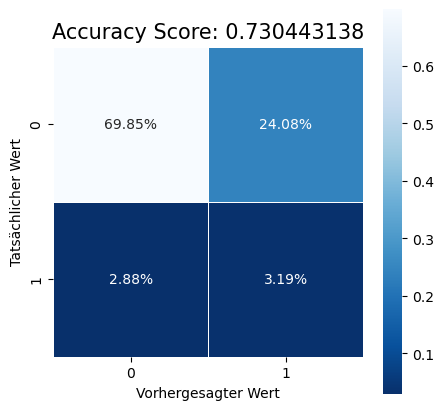

In [19]:
#Modellkalibrierung
logmodel = LogisticRegression(random_state=0, max_iter=1000)  
logmodel.fit(X_train_ex, y_train,sample_weight = w_train) 

#Modellprognosen
lgmod_pred = logmodel.predict_proba(X_test_ex)
lg_pred = 1* (lgmod_pred[:,1]> np.mean(y_test)) + 0

#Bewertung
Show_Metrics(y_test,lgmod_pred)

# Erstellen der Confusion Matrix 
Accuracy_Conf(y_test,lg_pred)

# Erstellen eines DataFrame mit den Attributen und ihren Koeffizienten
coef_table = pd.DataFrame({
    'Attribute': list(X_train_ex.columns),
    'Coefficient': logmodel.coef_.flatten()
})

# Sortieren nach den absoluten Werten der Koeffizienten
coef_table['Abs_Coefficient'] = coef_table['Coefficient'].abs()
sorted_coef_table = coef_table.sort_values(by='Abs_Coefficient', ascending=False)

# Auswahl der wichtigsten 10 Attribute
top_10_attributes = sorted_coef_table.head(10).drop(columns=['Abs_Coefficient'])

print(top_10_attributes)

The calibrated GLM is realistic and can predict the target variable well. It is suitable for further analyses.

## 3.2 Random Forest

Deviance Improvement: 0.045472
Predicted mean: 0.060065
Computed AUC: 0.687587


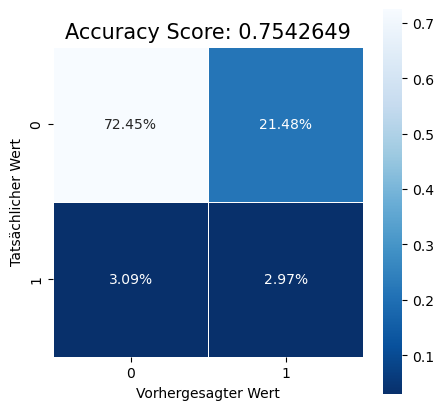

In [20]:
# Random Forest Modellbildung
rf = RandomForestClassifier(random_state = 42,
                            criterion = 'log_loss',
                            n_estimators = 200,
                            max_depth= 5) 
rf.fit(X_train_ex, y_train,sample_weight = w_train)

#Vorhersagen
rfmod_pred = rf.predict_proba(X_test_ex)
rf_pred = 1* (rfmod_pred[:,1]> np.mean(y_test)) + 0

#Bewertung
Show_Metrics(y_test,rfmod_pred)

# Erstellen der Confusion Matrix 
Accuracy_Conf(y_test,rf_pred)

### 3.3 XGBoost

Deviance Improvement: 0.062639
Predicted mean: 0.060463
Computed AUC: 0.692411


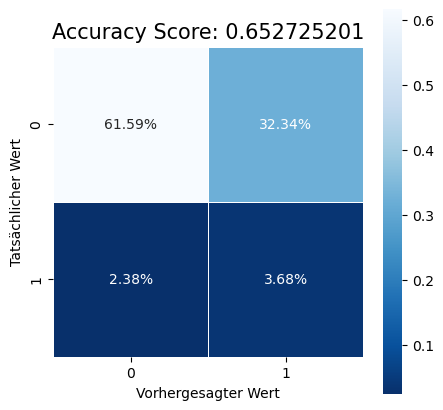

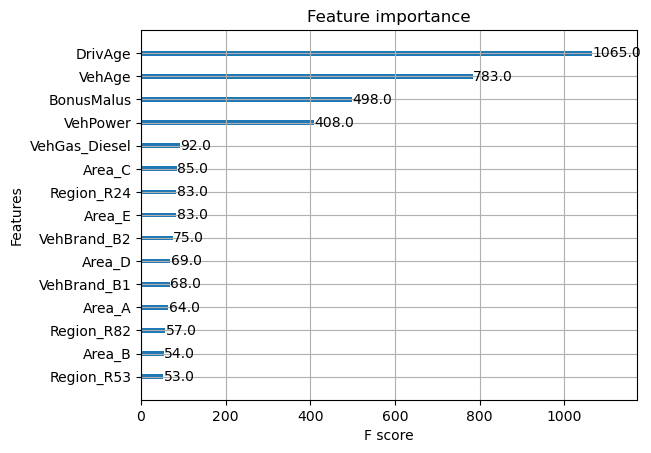

In [21]:
xgb_cl= xgb.XGBClassifier(random_state = 42,
                              eval_metric = 'logloss',
                              tree_method = 'hist'#,
                              #scale_pos_weight = 20
                         ) 
xgb_cl.fit(X_train_ex, y_train,sample_weight=w_train)
#Prognosen
xgbmod_pred = xgb_cl.predict_proba(X_test_ex)
xgb_pred = 1* (xgbmod_pred[:,1]> np.mean(y_test)) + 0


#Bewertung
Show_Metrics(y_test,xgbmod_pred)

# Erstellen der Confusion Matrix 
Accuracy_Conf(y_test,xgb_pred)

plot_importance(xgb_cl,max_num_features = 15)
plt.show()


**Conclusion of unawareness models:**
The developed models are all comparably good at predicting loss frequency (AUC between 68% and 70%).

## 4 Discrimination-Free Model for the modeling of ClaimsVP

Based on the methodology of Lindholm et al. (2021) (https://www.cambridge.org/core/services/aop-cambridge-core/content/view/ED25C4053690E56050F437B8DF2AD117/S0515036121000234a.pdf/discrimination-free-insurance-pricing.pdf), an approach for determining non-discriminatory insurance claims (Discrimination-Free Model) is applied. The effectiveness of this approach can be evaluated by comparing it with the Unawareness Model. The starting point is the calculation of a best-estimate model. This estimator first takes into account the protected characteristic in the differentiation and then integrates: 
$$ \mu(X) = \sum_{d\in D} \mu(X,d) P(D=d) $$
Here, 𝜇(𝑋) represents the expected claim frequency value based on the non-protected features X, while d represents a possible value of the protected feature D. 𝑃(𝐷=𝑑) indicates the probability of the occurrence of the respective value of the protected feature. This approach thus enables a balanced consideration of all relevant factors, while at the same time minimizing potential discrimination, as the influencing factors of the potentially discriminatory feature (D) are first modelled and then balanced via a frequency distribution of the feature.

The concept of the Discrimination-Free Model is based on the principle of fair insurance premium calculation, taking into account ethical and legal requirements. Lindholm et al. developed this approach to find a balance between actuarial fairness and protection against discrimination. We use this approach here to predict the claims frequency. 

This approach has the following scientific implications:

- **Independence:** The estimator is independent of the protected characteristic D (direct discrimination)
- **Information efficiency:** It uses all available information, including the indirect effects of the protected characteristic contained in the non-protected variables. (indirect discrimination)
- **•	Robustness:** The Discrimination-Free Estimator is robust to changes in the distribution of the protected feature in the population.

The practical implementation can be done by a two-step estimation as in this notebook:

Estimation of the best-estimate model 𝜇(X,D) and subsequent weighted averaging of all values of D.

This approach enables a scientifically sound, fair pricing (in this case, fair estimation of the claims frequency) in actuarial mathematics.

In [22]:
#Daten definieren
X = df_model_encoded.drop(['ClaimsVP'],axis=1)
y = df_model_encoded.ClaimsVP

# train and test split
X_train,X_test,y_train,y_test = sk.model_selection.train_test_split(X,y,test_size=0.33,random_state=42)

# Exposure entfernen
w_train = X_train.Exposure
X_train_ex = X_train.drop(['Exposure'],axis=1)
X_test_ex = X_test.drop(['Exposure'],axis=1)

### 4.1 Logistic Regression

Deviance Improvement: 0.073737
Predicted mean: 0.060495
Computed AUC: 0.709331
         Attribute  Coefficient
23  VehGas_Regular    -1.533039
22   VehGas_Diesel    -1.443410
8           Area_D    -0.527744
5           Area_A    -0.508847
7           Area_C    -0.507846
6           Area_B    -0.492836
9           Area_E    -0.490000
10          Area_F    -0.449175
4            SexVP     0.383358
0         VehPower     0.348038
12    VehBrand_B10    -0.326406


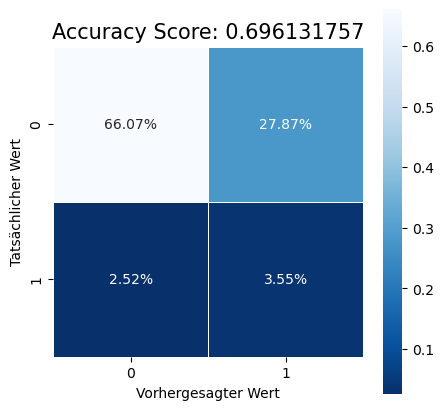

In [23]:
#Modellkalibrierung
logmodel_fair = LogisticRegression(random_state=0, max_iter=1000)  
logmodel_fair.fit(X_train_ex, y_train,sample_weight = w_train) 

#Modellprognosen
lgmod_pred_fair = logmodel_fair.predict_proba(X_test_ex)
lg_pred_fair = 1* (lgmod_pred_fair[:,1]> np.mean(y_test)) + 0

#Bewertung
Show_Metrics(y_test,lgmod_pred_fair)

# Erstellen der Confusion Matrix 
Accuracy_Conf(y_test,lg_pred_fair)

# Erstellen eines DataFrame mit den Attributen und ihren Koeffizienten
coef_table = pd.DataFrame({
    'Attribute': list(X_train_ex.columns),
    'Coefficient': logmodel_fair.coef_.flatten()
})

# Sortieren nach den absoluten Werten der Koeffizienten
coef_table['Abs_Coefficient'] = coef_table['Coefficient'].abs()
sorted_coef_table = coef_table.sort_values(by='Abs_Coefficient', ascending=False)

# Auswahl der wichtigsten 10 Attribute
top_11_attributes = sorted_coef_table.head(11).drop(columns=['Abs_Coefficient'])

print(top_11_attributes)

In [24]:
# Auswahl der wichtigsten 10 Attribute
top_11_attributes = sorted_coef_table.head(11).drop(columns=['Abs_Coefficient'])

print(top_11_attributes)

         Attribute  Coefficient
23  VehGas_Regular    -1.533039
22   VehGas_Diesel    -1.443410
8           Area_D    -0.527744
5           Area_A    -0.508847
7           Area_C    -0.507846
6           Area_B    -0.492836
9           Area_E    -0.490000
10          Area_F    -0.449175
4            SexVP     0.383358
0         VehPower     0.348038
12    VehBrand_B10    -0.326406


### 4.2 Random Forest

Deviance Improvement: 0.046955
Predicted mean: 0.060031
Computed AUC: 0.694792


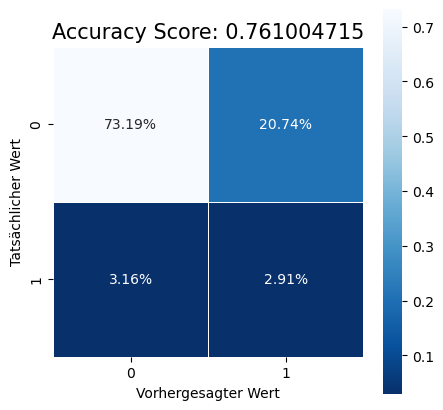

In [25]:
# Random Forest Modellbildung
rf_fair = RandomForestClassifier(random_state = 42,
                            criterion = 'log_loss',
                            n_estimators = 200,
                            max_depth= 5) 
rf_fair.fit(X_train_ex, y_train,sample_weight = w_train)

#Vorhersagen
rfmod_pred_fair = rf_fair.predict_proba(X_test_ex)
rf_pred_fair = 1* (rfmod_pred_fair[:,1]> np.mean(y_test)) + 0

#Bewertung
Show_Metrics(y_test,rfmod_pred_fair)

# Erstellen der Confusion Matrix 
Accuracy_Conf(y_test,rf_pred_fair)

### 4.3 XGBoost

Deviance Improvement: 0.070723
Predicted mean: 0.060425
Computed AUC: 0.699765


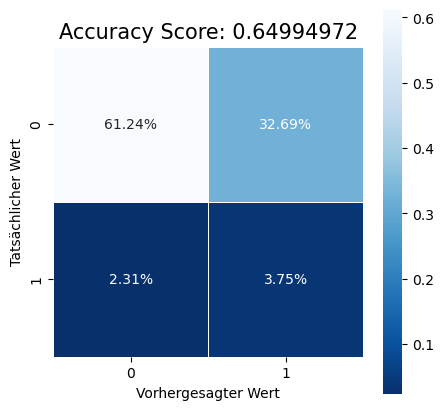

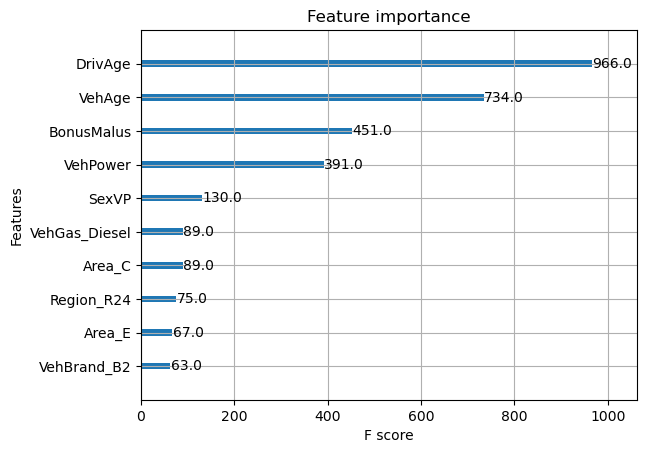

In [26]:
xgb_cl_fair= xgb.XGBClassifier(random_state = 42,
                              eval_metric = 'logloss',
                              tree_method = 'hist'#,
                              #scale_pos_weight = 20
                         ) 
xgb_cl_fair.fit(X_train_ex, y_train,sample_weight=w_train)
#Prognosen
xgbmod_pred_fair = xgb_cl_fair.predict_proba(X_test_ex)
xgb_pred_fair = 1* (xgbmod_pred_fair[:,1]> np.mean(y_test)) + 0


#Bewertung
Show_Metrics(y_test,xgbmod_pred_fair)

# Erstellen der Confusion Matrix 
Accuracy_Conf(y_test,xgb_pred_fair)

plot_importance(xgb_cl_fair,max_num_features = 10)
plt.show()


**Conclusion best-estimate models:**
The models developed are all comparably good at predicting the claim frequencies (AUC between 69.5% - 70.9%). The best-estimate models consistently have an AUC that is around 0.5% higher than that of the unawareness models. 

The second necessary criteria for the existence of indirect discrimination is therefore fulfilled, cf. chapter 2.

If we compare the largest coefficients in terms of contribution in the logistic regression (cf. Table 3), it can be concluded that:

- The characteristic "SexVP" is a relevant feature in the best-estimate model. The value of 0.348 reflects the enriched, direct correlation between gender and claim frequency (more frequent for women).
- If the "SexVP" feature is removed (transition to the unawareness model), this correlation is taken up by the other features in that the majority of coefficients are larger in terms of contribution. The feature whose coefficient does not increase is the proxy feature "VehPower". This illustrates the effect of indirect discrimination. The influence of "VehPower" is actually larger. However, as the direct correlation with women must now be balanced out (women in the data set drive vehicles with lower engine power on average), the coefficient of "VehPower" is reduced. People with vehicles with higher engine power are favored.

### 4.4 Derivation of a Discrimination-Free Model

In [27]:
#proportion Männer:
prop_male = X_train.SexVP.value_counts(normalize=True)[1]
#male
X_test_ex_m = X_test_ex
X_test_ex_m.SexVP = 0
lgmod_pred_fair_m = logmodel_fair.predict_proba(X_test_ex_m)
rfmod_pred_fair_m = rf_fair.predict_proba(X_test_ex_m)
xgbmod_pred_fair_m = xgb_cl_fair.predict_proba(X_test_ex_m)

#female
X_test_ex_f = X_test_ex
X_test_ex_f.SexVP = 1
lgmod_pred_fair_f = logmodel_fair.predict_proba(X_test_ex_f)
rfmod_pred_fair_f = rf_fair.predict_proba(X_test_ex_f)
xgbmod_pred_fair_f = xgb_cl_fair.predict_proba(X_test_ex_f)

#Discrimination Free Insurance Price
lgmod_pred_fair = prop_male * lgmod_pred_fair_m + (1-prop_male) * lgmod_pred_fair_f 
rfmod_pred_fair = prop_male * rfmod_pred_fair_m + (1-prop_male) * rfmod_pred_fair_f 
xgbmod_pred_fair = prop_male * xgbmod_pred_fair_m + (1-prop_male) * xgbmod_pred_fair_f 


#Bewertung
Show_Metrics(y_test,lgmod_pred_fair)
Show_Metrics(y_test,rfmod_pred_fair)
Show_Metrics(y_test,xgbmod_pred_fair)

Deviance Improvement: 0.068474
Predicted mean: 0.062256
Computed AUC: 0.702091
Deviance Improvement: 0.046149
Predicted mean: 0.059854
Computed AUC: 0.688733
Deviance Improvement: 0.063158
Predicted mean: 0.059980
Computed AUC: 0.694262


In [28]:
X_evaluate = X_test[['SexVP']]
X_evaluate=X_evaluate.assign(unaware_log = lgmod_pred[:,1],
                  fair_log = lgmod_pred_fair[:,1],
                  unaware_rf = rfmod_pred[:,1],
                  fair_rf = rfmod_pred_fair[:,1],
                  unaware_xgb = xgbmod_pred[:,1],
                  fair_xgb = xgbmod_pred_fair[:,1],
                  Claims = y_test,
                  anz = 1)
X_aggregate = X_evaluate.groupby(['SexVP','Claims']).sum()
divided_df = X_aggregate.assign(**{col: X_aggregate[col] / X_aggregate['anz'] for col in ['unaware_log', 'fair_log', 'unaware_rf', 'fair_rf','unaware_xgb', 'fair_xgb']})
print(divided_df)

              unaware_log  fair_log  unaware_rf   fair_rf  unaware_xgb  \
SexVP Claims                                                             
0.0   0          0.069049  0.071870    0.063706  0.063464     0.068886   
      1          0.137337  0.149244    0.088483  0.088156     0.132138   
1.0   0          0.046919  0.046957    0.054501  0.054327     0.047187   
      1          0.062764  0.064380    0.062032  0.061824     0.065159   

              fair_xgb     anz  
SexVP Claims                    
0.0   0       0.068648  103892  
      1       0.133603    7048  
1.0   0       0.046328  106276  
      1       0.064797    6529  


**Conclusion**: The application of the Discrimination-Free Model was able to remove the indirect discrimination in this example, which was visible on the basis of a coefficient comparison of the logistic regression. This approach is easy to implement in practice. The following steps are necessary:

1. Examination of the necessary criteria: The first step is to develop a simple model for predicting gender. Then, as is already common practice, the unawareness model is developed and, building on this, the best-estimate model.

2. Afterwards, a comparison of the coefficients can give hints to identify any proxy variables.

3. Finally, the weighted combination of the best estimate models for women and men, the Discrimination-Free Model, is derived. As in our example, it can turn out that the performance is rather similar. However, the model has a clear advantage with respect to fairness.



## 5 Analysis of fairness metrics
### 5.1 Demographic Parity
Demographic parity can be used to assess the dependency of the target variables on the protected feature. Ideally, these are independent. With the demographic parity ratio, a value close to 1 means that a model makes similar predictions for the selected sensitive attribute, i.e. is "fair". This is much more suitable for unbalanced predictions than the demographic parity difference.

In [29]:
dp_ratio_log = demographic_parity_ratio(   
                    y_true=y_test, 
                    y_pred=lg_pred,
                    sensitive_features=X_test.SexVP)

In [30]:
dp_ratio_rf = demographic_parity_ratio(
                    y_true=y_test, 
                    y_pred=rf_pred,
                    sensitive_features=X_test.SexVP)

In [31]:
dp_ratio_xgb = demographic_parity_ratio(
                    y_true=y_test, 
                    y_pred=xgb_pred,
                    sensitive_features=X_test.SexVP)

In [32]:
print("Demographic Parity Ratio for Logit Model: {:f}".format(dp_ratio_log))
print("Demographic Parity Ratio for Random Forest:  {:f}".format(dp_ratio_rf))
print("Demographic Parity Ratio for XGBoost:  {:f}".format(dp_ratio_xgb))

Demographic Parity Ratio for Logit Model: 0.534837
Demographic Parity Ratio for Random Forest:  0.505504
Demographic Parity Ratio for XGBoost:  0.639319


In [33]:
# Manuelle Berechnung des Demographic Parity

# Konvertierung der Wahrscheinlichkeiten in binäre Vorhersagen
# Verwendet den Mittelwert von y_test als Schwellenwert
lg_pred = 1 * (lgmod_pred[:,1] > np.mean(y_test)) + 0

ind_sex = X_test['SexVP'] == 0

# Berechnung des Demographic Parity wie vom Paket durchgeführt
# Verhältnis der Mittelwerte der Vorhersagen für die beiden Geschlechtergruppen
print("Das Paket macht: {:f}".format(np.mean(lg_pred[-ind_sex]) / np.mean(lg_pred[ind_sex])))

print("Genauer wäre die Berechnung auf Basis der Wahrscheinlichkeiten:")

# Berechnung für das logistische Regressionsmodell
# Verwendet die vorhergesagten Wahrscheinlichkeiten statt binärer Klassifikationen
print("log: {:f}".format(np.mean(lgmod_pred[-ind_sex,1]) / np.mean(lgmod_pred[ind_sex,1])))

# Berechnung für das XGBoost-Modell
print("xgb: {:f}".format(np.mean(xgbmod_pred[-ind_sex,1]) / np.mean(xgbmod_pred[ind_sex,1])))

print("und für die Discrimination-Free Claims:")

# Berechnung für das faire logistische Regressionsmodell
print("log: {:f}".format(np.mean(lgmod_pred_fair[-ind_sex,1]) / np.mean(lgmod_pred_fair[ind_sex,1])))

# Berechnung für das faire XGBoost-Modell
print("xgb: {:f}".format(np.mean(xgbmod_pred_fair[-ind_sex,1]) / np.mean(xgbmod_pred_fair[ind_sex,1])))

Das Paket macht: 0.534837
Genauer wäre die Berechnung auf Basis der Wahrscheinlichkeiten:
log: 0.651828
xgb: 0.661509
und für die Discrimination-Free Claims:
log: 0.624668
xgb: 0.651287


When evaluating demographic parity, it is important to take a critical look at the calculation methodology. In this case, the software package used employs binary predictions (0/1). However, this approach has inherent limitations.

A more precise analysis is possible by using the probabilities predicted by the model. The advantage of this approach lies in the consideration of prediction uncertainty, especially for cases close to the decision boundary. With binary classification, these borderline cases are forced into discrete categories, which can lead to an overemphasis on small differences and thus distort the overall assessment of fairness.

The observed values deviate significantly from 1, which at first glance indicates a significant violation of the demographic parity principle. The more detailed analysis using the continuous probability values shows a slightly better picture of the fairness situation. This method reveals more subtle differences in the treatment of different demographic groups by the model. However, the values here also deviate considerably from 1.

**Conclusion:** Both models show comparable fairness on the basis of the demographic parity ratio. The application of the Discrimination-Free Model does not improve the view of demographic parity. This finding was already made by Lindholm et al. (2023). This raises doubts whether these metrics are suitable for recognizing indirect discrimination at all, see Lindholm et al. (2023).

## Equalized Odds

In the analysis of fairness in machine learning algorithms  , the concept of "equalized odds" represents another possibility. This fairness criterion aims to ensure equal treatment of different demographic groups with regard to the predictive accuracy of the model.

An Equalized Odds Ratio of 1 means that the same True Positive (TP), True Negative (TN), False Positive (FP) and False Negative (FN) rates are estimated for all groups considered. In other words, the model has the same accuracy, sensitivity and specificity for each group, regardless of group membership.

In the following analysis, we will examine the equalized odds of our models, paying particular attention to the use of probabilities instead of binary classifications, analogous to demographic parity. This approach also enables a more precise assessment of model fairness by taking into account the uncertainty in the predictions and avoiding information loss through discretization.

In [34]:
eo_ratio_log = equalized_odds_ratio(   
                    y_true=y_test, 
                    y_pred=lg_pred,
                    sensitive_features=X_test.SexVP)
eo_ratio_rf = equalized_odds_ratio(   
                    y_true=y_test, 
                    y_pred=rf_pred,
                    sensitive_features=X_test.SexVP)
eo_ratio_xgb = equalized_odds_ratio(   
                    y_true=y_test, 
                    y_pred=xgb_pred,
                    sensitive_features=X_test.SexVP)

print("Equalized Odds Ratio Logit Model: {:f}".format(eo_ratio_log))
print("Equalized Odds Ratio Random Forest:  {:f}".format(eo_ratio_rf))
print("Equalized Odds Ratio XGBoost:  {:f}".format(eo_ratio_xgb))

Equalized Odds Ratio Logit Model: 0.497326
Equalized Odds Ratio Random Forest:  0.466556
Equalized Odds Ratio XGBoost:  0.592575


In [35]:
# Manuelle Berechnung der Equal Opportunity und Equalized Odds Metriken

# True Positive Rate (TPR) Berechnung
# Indizes für wahre positive Fälle, getrennt nach Geschlecht
ind_sex_target = ((X_test['SexVP'] == 0) & (y_test == 1))  # Weiblich und positiv
ind_sex_target2 = ((X_test['SexVP'] == 1) & (y_test == 1))  # Männlich und positiv

# Berechnung des TPR-Verhältnisses (männlich zu weiblich)
print("Das Paket macht das Minimum aus tpr: {:f}".format(np.mean(lg_pred[ind_sex_target2]) / np.mean(lg_pred[ind_sex_target])))

# False Positive Rate (FPR) Berechnung
# Indizes für falsche positive Fälle, getrennt nach Geschlecht
ind_sex_targetfp = ((X_test['SexVP'] == 0) & (y_test == 0))  # Weiblich und negativ
ind_sex_target2fp = ((X_test['SexVP'] == 1) & (y_test == 0))  # Männlich und negativ

# Berechnung des FPR-Verhältnisses (männlich zu weiblich)
print("und fpr: {:f}".format(np.mean(lg_pred[ind_sex_target2fp]) / np.mean(lg_pred[ind_sex_targetfp])))

print("Besser wäre erneut auf Basis der Wahrscheinlichkeiten:")

# Berechnung auf Basis der Wahrscheinlichkeiten für das logistische Regressionsmodell
print("Minimum aus tpr {:f}".format(np.mean(lgmod_pred[ind_sex_target2,1]) / np.mean(lgmod_pred[ind_sex_target,1])))
print("und fpr: {:f}".format(np.mean(lgmod_pred[ind_sex_target2fp,1]) / np.mean(lgmod_pred[ind_sex_targetfp,1])))

# Berechnung für das Discrimination-Free Claims Modell
print("Für den Discrimination-Free Claims das Minimum aus tpr: {:f}".format(np.mean(lgmod_pred_fair[ind_sex_target2,1]) / np.mean(lgmod_pred_fair[ind_sex_target,1])))
print('und fpr: {:f}'.format(np.mean(lgmod_pred_fair[ind_sex_target2fp,1]) / np.mean(lgmod_pred_fair[ind_sex_targetfp,1])))

Das Paket macht das Minimum aus tpr: 0.497326
und fpr: 0.543093
Besser wäre erneut auf Basis der Wahrscheinlichkeiten:
Minimum aus tpr 0.457011
und fpr: 0.679499
Für den Discrimination-Free Claims das Minimum aus tpr: 0.431378
und fpr: 0.653360


**Conclusion:** The analysis shows clear differences between the calculation methods for TPR and FPR. The probability-based method is also preferable here, as it provides a more precise picture of the model performance and takes into account the uncertainty in the predictions. 

The small differences between the original and the Discrimination-Free Claims Model indicate a limited effectiveness of the applied fairness correction. Both models continue to show deviations from perfect fairness (TPR and FPR ratios ≠ 1), which from this perspective indicates persistent inequalities (see conclusion on demographic parity). 

These results underline the complexity of the fairness assessment and the need for a holistic view of various metrics for a profound assessment of a models fairness.